In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain'
val_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/ValData'

In [ ]:
num_classes_train = len(os.listdir(train_path))
print("There are %d classes in the train dataset." %num_classes_train)

There are 4 classes in the train dataset.


In [ ]:
num_classes_val = len(os.listdir(val_path))
print("There are %d classes in the validation dataset." %num_classes_val)

There are 4 classes in the validation dataset.


In [ ]:
##  we'll explore more of the train dataset..

BP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/BacterialPneumonia'
img_list_bp = os.listdir(BP_path)

print('There are %d images of Bacterial Pneumonia present in the Train dataste.' %(len(img_list_bp)))

There are 650 images of Bacterial Pneumonia present in the Train dataste.


In [ ]:
covid_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/COVID-19'
img_list_covid = os.listdir(covid_path)

print('There are %d images of COVID-19 present in the Train dataste.' %(len(img_list_covid)))

There are 60 images of COVID-19 present in the Train dataste.


In [ ]:
normal_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/Normal'
img_list_normal = os.listdir(normal_path)

print('There are %d images of Normal lung present in the Train dataste.' %(len(img_list_normal)))

There are 880 images of Normal lung present in the Train dataste.


In [ ]:
VP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/ViralPneumonia'
img_list_vp = os.listdir(VP_path)

print('There are %d images of Viral Pneumonia present in the Train dataste.' %(len(img_list_vp)))

There are 412 images of Viral Pneumonia present in the Train dataste.


In [ ]:
batch_size = 32
image_size = (224, 224)

In [ ]:
train_gen = ImageDataGenerator(                                                            
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input,
                                fill_mode='nearest')

In [ ]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_ds = train_gen.flow_from_directory(train_path,
                                         target_size=image_size,
                                         class_mode='sparse',
                                         batch_size=batch_size,
                                         shuffle=True)

Found 2002 images belonging to 4 classes.


In [ ]:
images, labels = next(iter(train_ds))
print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [ ]:
val_ds = val_gen.flow_from_directory(val_path,
                                     target_size=image_size,
                                     class_mode='sparse',
                                     batch_size=batch_size,
                                     shuffle=True)

Found 988 images belonging to 4 classes.


In [ ]:
num_classes = train_ds.num_classes
num_classes

4

In [ ]:
train_ds.class_indices

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}

In [ ]:
class_labels = list(train_ds.class_indices.keys())
class_labels


['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']

In [ ]:
## defining the  base Vgg16 model..

img_shape = image_size + (3,)

basemodel_vgg16 = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
basemodel_vgg16.trainable = False

In [ ]:
basemodel_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
## Constructing a new model by adding the classification layer on top of the base model 

x = basemodel_vgg16.output
x = Flatten(name="flatten")(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

#define new model
model = Model(inputs=basemodel_vgg16.input, outputs=output)

In [ ]:
base_lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
## lets train the model with the new added classifier for 10 epochs

init_epoch = 10

history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    epochs=init_epoch,
                    validation_data=val_ds,
                    validation_steps=len(val_ds))

Epoch 1/10
63/63 [==============================] - 693s 11s/step - loss: 4.0439 - accuracy: 0.6259 - val_loss: 2.2090 - val_accuracy: 0.7227
Epoch 2/10
63/63 [==============================] - 43s 685ms/step - loss: 1.9387 - accuracy: 0.6973 - val_loss: 1.9359 - val_accuracy: 0.7277
Epoch 3/10
63/63 [==============================] - 43s 689ms/step - loss: 1.2989 - accuracy: 0.7078 - val_loss: 1.2805 - val_accuracy: 0.7429
Epoch 4/10
63/63 [==============================] - 43s 688ms/step - loss: 0.9996 - accuracy: 0.7163 - val_loss: 1.0073 - val_accuracy: 0.7500
Epoch 5/10
63/63 [==============================] - 43s 685ms/step - loss: 0.8069 - accuracy: 0.7098 - val_loss: 0.9883 - val_accuracy: 0.7368
Epoch 6/10
63/63 [==============================] - 43s 687ms/step - loss: 0.6845 - accuracy: 0.7163 - val_loss: 1.1617 - val_accuracy: 0.7328
Epoch 7/10
63/63 [==============================] - 43s 686ms/step - loss: 0.6245 - accuracy: 0.7537 - val_loss: 1.1259 - val_accuracy: 0.7308


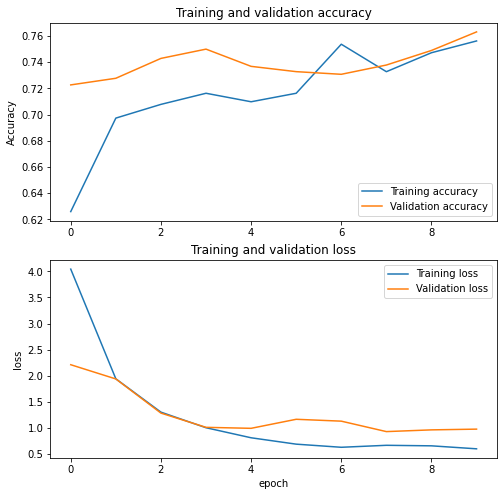

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
#plt.ylim([min(plt.ylim()),1])
plt.title("Training and validation accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel("loss")
#plt.ylim(0,1.0)
plt.title("Training and validation loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
## lets do some fine tuning to see whether we can improve the model's accuracy

In [ ]:
# Let's take a look to see how many layers are in the base model vgg16

print("Number of layers in the base model: ", len(basemodel_vgg16.layers))

Number of layers in the base model:  19


In [ ]:
## lets check out the layers by name and the layers are trainable or not..

for i , layer in enumerate(basemodel_vgg16.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
## lets start fine tune from #15(i.e from block5)

fine_tune_at = 15

for layer in basemodel_vgg16.layers[:fine_tune_at]:
  layer.trainable = False

for layer in basemodel_vgg16.layers[fine_tune_at:]:
  layer.trainable = True

In [ ]:
## lets recompile the model

base_lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
fine_tune_epoch = 25

filepath_checkpoint = 'best_VGG16_model.h5'

checkpoint = ModelCheckpoint(filepath_checkpoint,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           mode='max')

callbacks_list = [checkpoint, early_stop]

history_tuned = model.fit(train_ds,
                          steps_per_epoch=len(train_ds),
                          epochs=fine_tune_epoch,
                          initial_epoch=history.epoch[-1],
                          shuffle=True,
                          validation_data=val_ds,
                          validation_steps=len(val_ds),                                    
                          callbacks=callbacks_list) 

Epoch 10/25
63/63 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7677
Epoch 00010: val_accuracy improved from -inf to 0.74899, saving model to best_VGG16_model.h5
63/63 [==============================] - 45s 714ms/step - loss: 0.5559 - accuracy: 0.7677 - val_loss: 0.7525 - val_accuracy: 0.7490
Epoch 11/25
63/63 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7872
Epoch 00011: val_accuracy improved from 0.74899 to 0.75304, saving model to best_VGG16_model.h5
63/63 [==============================] - 44s 700ms/step - loss: 0.5082 - accuracy: 0.7872 - val_loss: 0.8537 - val_accuracy: 0.7530
Epoch 12/25
63/63 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7927
Epoch 00012: val_accuracy did not improve from 0.75304
63/63 [==============================] - 44s 692ms/step - loss: 0.4999 - accuracy: 0.7927 - val_loss: 1.0935 - val_accuracy: 0.7530
Epoch 13/25
63/63 [==============================] - ETA: 0s - loss: 0.4719

In [ ]:
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']

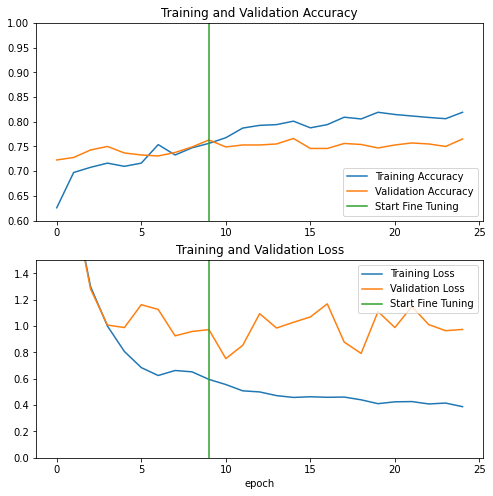

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([init_epoch-1,init_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([init_epoch-1,init_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model = keras.models.load_model('best_VGG16_model.h5')

In [ ]:
#class_names = ['BacterialPneumonia', 'COVID-19','Normal','ViralPneumonia']

test_img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/BacterialPneumonia/148.jpeg', target_size=(224,224)) 
img = keras.preprocessing.image.img_to_array(test_img)
img = preprocess_input(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.nn.softmax(prediction[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
       .format(class_labels[np.argmax(score)], 100*np.max(score))      
      )

This image most likely belongs to BacterialPneumonia with a 40.89 percent confidence.


In [ ]:
## classification report

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(val_path,
                                       target_size=image_size,
                                       class_mode='sparse',
                                       batch_size=batch_size,
                                       shuffle=False)

test_steps_per_epoch = len(test_ds)

predictions = model.predict(test_ds, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_ds.classes
test_class_labels = list(test_ds.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=test_class_labels)
print(report)    




Found 988 images belonging to 4 classes.
                    precision    recall  f1-score   support

BacterialPneumonia       0.69      0.78      0.74       324
          COVID-19       0.75      0.67      0.71         9
            Normal       0.81      1.00      0.90       450
    ViralPneumonia       0.80      0.23      0.36       205

          accuracy                           0.77       988
         macro avg       0.76      0.67      0.67       988
      weighted avg       0.77      0.77      0.73       988



In [ ]:
## lets plot the confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot   

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    #import matplotlib.pyplot as plt
    #import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

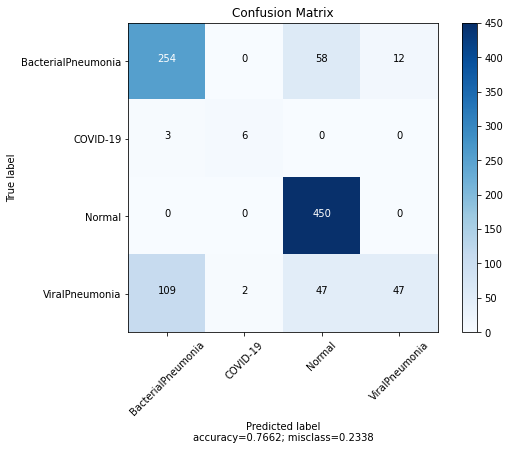

In [ ]:
prediction = model.predict(test_ds)
y_pred = np.argmax(prediction, axis=1)

cm = confusion_matrix(true_classes, y_pred)

plot_confusion_matrix(cm,          
                      normalize    = False,
                      target_names = test_class_labels,
                      title        = "Confusion Matrix")